In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(2, activation='relu'))
        
    model.add(layers.Dense(2, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 3.4776 - mae: 1.5724 - mape: 76.1996 - student_loss: 1.5711 - distillation_loss: 3.0122 - val_mse: 2.0993 - val_mae: 1.1200 - val_mape: 50.1219 - val_student_loss: 1.2444
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3907 - mae: 0.8796 - mape: 45.6391 - student_loss: 0.8815 - distillation_loss: 0.9476 - val_mse: 0.9913 - val_mae: 0.7673 - val_mape: 50.6727 - val_student_loss: 1.1041
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9672 - mae: 0.7765 - mape: 53.6005 - student_loss: 0.7789 - distillation_loss: 0.5308 - val_mse: 0.9375 - val_mae: 0.7727 - val_mape: 56.7844 - val_student_loss: 1.1440
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9550 - mae: 0.7829 - mape: 55.9582 - student_loss: 0.7813 - distillation_loss: 0.5158 - val_mse: 0.9336 - val_mae: 0.7732 - val_mape: 57.0832 - val_student_loss: 1.1461
Epoch 5/100
4

443/443 [==============================] - 1s 2ms/step - mse: 0.9540 - mae: 0.7829 - mape: 55.9741 - student_loss: 0.7811 - distillation_loss: 0.5147 - val_mse: 0.9328 - val_mae: 0.7707 - val_mape: 56.3963 - val_student_loss: 1.1426
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7826 - mape: 55.9367 - student_loss: 0.7857 - distillation_loss: 0.5176 - val_mse: 0.9325 - val_mae: 0.7740 - val_mape: 57.3476 - val_student_loss: 1.1478
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9538 - mae: 0.7831 - mape: 56.0245 - student_loss: 0.7847 - distillation_loss: 0.5168 - val_mse: 0.9326 - val_mae: 0.7742 - val_mape: 57.4023 - val_student_loss: 1.1481
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7831 - mape: 56.0229 - student_loss: 0.7825 - distillation_loss: 0.5156 - val_mse: 0.9325 - val_mae: 0.7727 - val_mape: 57.0088 - val_student_loss: 1.1460
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9540 - mae: 0.7828 - mape: 55.9470 - student_loss: 0.7853 - distillation_loss: 0.5197 - val_mse: 0.9325 - val_mae: 0.7727 - val_mape: 57.0002 - val_student_loss: 1.1459
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9541 - mae: 0.7828 - mape: 55.9481 - student_loss: 0.7835 - distillation_loss: 0.5150 - val_mse: 0.9328 - val_mae: 0.7753 - val_mape: 57.7062 - val_student_loss: 1.1497
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9542 - mae: 0.7835 - mape: 56.1031 - student_loss: 0.7819 - distillation_loss: 0.5153 - val_mse: 0.9331 - val_mae: 0.7700 - val_mape: 56.1935 - val_student_loss: 1.1414
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9538 - mae: 0.7829 - mape: 55.9731 - student_loss: 0.7815 - distillation_loss: 0.5150 - val_mse: 0.9325 - val_mae: 0.7723 - val_mape: 56.8838 - val_student_loss: 1.1453
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7827 - mape: 55.9387 - student_loss: 0.7817 - distillation_loss: 0.5163 - val_mse: 0.9325 - val_mae: 0.7733 - val_mape: 57.1630 - val_student_loss: 1.1468
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7095 - mse: 3.8951 - mae: 1.7095 - mape: 84.7899 - val_loss: 1.4705 - val_mse: 3.0941 - val_mae: 1.4705 - val_mape: 69.5410
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2925 - mse: 2.6022 - mae: 1.2925 - mape: 58.1569 - val_loss: 1.1106 - val_mse: 2.0653 - val_mae: 1.1106 - val_mape: 49.6799
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0108 - mse: 1.7992 - mae: 1.0108 - mape: 45.7536 - val_loss: 0.9137 - val_mse: 1.4889 - val_mae: 0.9137 - val_mape: 44.5234
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8664 - mse: 1.3633 - mae: 0.8664 - mape: 43.6706 - val_loss: 0.8188 - val_mse: 1.1865 -

443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9893 - mae: 0.7704 - mape: 50.2663 - val_loss: 0.7633 - val_mse: 0.9644 - val_mae: 0.7633 - val_mape: 51.4152
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9882 - mae: 0.7704 - mape: 50.3632 - val_loss: 0.7633 - val_mse: 0.9639 - val_mae: 0.7633 - val_mape: 51.4832
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9879 - mae: 0.7704 - mape: 50.3765 - val_loss: 0.7634 - val_mse: 0.9648 - val_mae: 0.7634 - val_mape: 51.3894
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9896 - mae: 0.7704 - mape: 50.2236 - val_loss: 0.7632 - val_mse: 0.9628 - val_mae: 0.7632 - val_mape: 51.5151
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9877 - mae: 0.7704 - mape: 50.3775 - val_loss: 0.7633 - val_mse: 0.9637 - val_mae: 0.7633 - val_mape: 51.5056
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9877 - mae: 0.7701 - mape: 50.3066 - val_loss: 0.7635 - val_mse: 0.9640 - val_mae: 0.7635 - val_mape: 51.6086
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7702 - mse: 0.9867 - mae: 0.7702 - mape: 50.4275 - val_loss: 0.7636 - val_mse: 0.9667 - val_mae: 0.7636 - val_mape: 51.3028
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9884 - mae: 0.7701 - mape: 50.2800 - val_loss: 0.7637 - val_mse: 0.9664 - val_mae: 0.7637 - val_mape: 51.3678
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9880 - mae: 0.7701 - mape: 50.2819 - val_loss: 0.7636 - val_mse: 0.9652 - val_mae: 0.7636 - val_mape: 51.4971
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7701 - mse: 0.9875 - mae: 0.7701 - mape: 50.3507 - val_loss: 0.7636 - val_mse: 0.9649 - val_mae: 0.7636 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9555 - mae: 0.7741 - mape: 53.9898 - student_loss: 0.7747 - distillation_loss: 0.5164 - val_mse: 0.9680 - val_mae: 0.7829 - val_mape: 54.3381 - val_student_loss: 0.7570
Epoch 19/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9517 - mae: 0.7775 - mape: 55.1059 - student_loss: 0.7781 - distillation_loss: 0.5148 - val_mse: 0.9656 - val_mae: 0.7855 - val_mape: 55.1497 - val_student_loss: 0.7803
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9506 - mae: 0.7796 - mape: 55.6942 - student_loss: 0.7793 - distillation_loss: 0.5131 - val_mse: 0.9648 - val_mae: 0.7870 - val_mape: 55.5738 - val_student_loss: 0.7923
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7805 - mape: 55.9568 - student_loss: 0.7795 - distillation_loss: 0.5136 - val_mse: 0.9646 - val_mae: 0.7874 - val_mape: 55.6856 - val_student_loss: 0.7954
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.9502 - mae: 0.7806 - mape: 55.9686 - student_loss: 0.7799 - distillation_loss: 0.5133 - val_mse: 0.9642 - val_mae: 0.7886 - val_mape: 56.0177 - val_student_loss: 0.8045
Epoch 52/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9502 - mae: 0.7818 - mape: 56.2715 - student_loss: 0.7804 - distillation_loss: 0.5120 - val_mse: 0.9647 - val_mae: 0.7870 - val_mape: 55.5871 - val_student_loss: 0.7926
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9503 - mae: 0.7807 - mape: 55.9944 - student_loss: 0.7799 - distillation_loss: 0.5118 - val_mse: 0.9643 - val_mae: 0.7882 - val_mape: 55.8977 - val_student_loss: 0.8012
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9502 - mae: 0.7814 - mape: 56.1702 - student_loss: 0.7810 - distillation_loss: 0.5110 - val_mse: 0.9645 - val_mae: 0.7877 - val_mape: 55.7881 - val_student_loss: 0.7982
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7812 - mape: 56.1194 - student_loss: 0.7811 - distillation_loss: 0.5120 - val_mse: 0.9643 - val_mae: 0.7883 - val_mape: 55.9399 - val_student_loss: 0.8024
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9501 - mae: 0.7816 - mape: 56.2180 - student_loss: 0.7799 - distillation_loss: 0.5125 - val_mse: 0.9647 - val_mae: 0.7871 - val_mape: 55.6281 - val_student_loss: 0.7938
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7809 - mape: 56.0475 - student_loss: 0.7797 - distillation_loss: 0.5130 - val_mse: 0.9643 - val_mae: 0.7882 - val_mape: 55.9138 - val_student_loss: 0.8017
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7817 - mape: 56.2434 - student_loss: 0.7802 - distillation_loss: 0.5122 - val_mse: 0.9648 - val_mae: 0.7868 - val_mape: 55.5284 - val_student_loss: 0.7910
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9847 - mae: 0.7691 - mape: 50.4371 - val_loss: 0.7772 - val_mse: 1.0016 - val_mae: 0.7772 - val_mape: 50.3845
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9831 - mae: 0.7691 - mape: 50.5729 - val_loss: 0.7771 - val_mse: 1.0023 - val_mae: 0.7771 - val_mape: 50.3238
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9832 - mae: 0.7691 - mape: 50.5455 - val_loss: 0.7772 - val_mse: 0.9976 - val_mae: 0.7772 - val_mape: 50.6848
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7692 - mse: 0.9809 - mae: 0.7692 - mape: 50.7627 - val_loss: 0.7769 - val_mse: 1.0077 - val_mae: 0.7769 - val_mape: 49.8739
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9849 - mae: 0.7691 - mape: 50.4320 - val_loss: 0.7771 - val_mse: 1.0000 - val_mae: 0.7771 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9859 - mae: 0.7691 - mape: 50.3629 - val_loss: 0.7770 - val_mse: 0.9988 - val_mae: 0.7770 - val_mape: 50.5178
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9828 - mae: 0.7691 - mape: 50.6050 - val_loss: 0.7773 - val_mse: 1.0056 - val_mae: 0.7773 - val_mape: 50.1291
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7691 - mse: 0.9843 - mae: 0.7691 - mape: 50.4729 - val_loss: 0.7771 - val_mse: 0.9992 - val_mae: 0.7771 - val_mape: 50.5241
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7692 - mse: 0.9821 - mae: 0.7692 - mape: 50.6569 - val_loss: 0.7775 - val_mse: 1.0051 - val_mae: 0.7775 - val_mape: 50.2082
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7692 - mse: 0.9850 - mae: 0.7692 - mape: 50.4512 - val_loss: 0.7778 - val_mse: 1.0014 - val_mae: 0.7778 - val_mape: 50.5698
Epo

443/443 [==============================] - 1s 2ms/step - mse: 4.0213 - mae: 1.7217 - mape: 85.9121 - student_loss: 1.7215 - distillation_loss: 3.5588 - val_mse: 3.2395 - val_mae: 1.5102 - val_mape: 71.2477 - val_student_loss: 1.1609
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7816 - mae: 1.3344 - mape: 60.5021 - student_loss: 1.3332 - distillation_loss: 2.3212 - val_mse: 2.2610 - val_mae: 1.1703 - val_mape: 51.3287 - val_student_loss: 0.8866
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9669 - mae: 1.0542 - mape: 47.0641 - student_loss: 1.0543 - distillation_loss: 1.5123 - val_mse: 1.6392 - val_mae: 0.9584 - val_mape: 44.3752 - val_student_loss: 0.7350
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4656 - mae: 0.8891 - mape: 43.5467 - student_loss: 0.8914 - distillation_loss: 1.0194 - val_mse: 1.2756 - val_mae: 0.8465 - val_mape: 44.6427 - val_student_loss: 0.7350
Epoch 5/100
443/443 [===========

443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7806 - mape: 55.9274 - student_loss: 0.7790 - distillation_loss: 0.5117 - val_mse: 0.9620 - val_mae: 0.7938 - val_mape: 57.5640 - val_student_loss: 0.7350
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7805 - mape: 55.9119 - student_loss: 0.7789 - distillation_loss: 0.5108 - val_mse: 0.9622 - val_mae: 0.7929 - val_mape: 57.3335 - val_student_loss: 0.7350
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9507 - mae: 0.7802 - mape: 55.8285 - student_loss: 0.7804 - distillation_loss: 0.5123 - val_mse: 0.9621 - val_mae: 0.7934 - val_mape: 57.4520 - val_student_loss: 0.7350
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9508 - mae: 0.7801 - mape: 55.8159 - student_loss: 0.7803 - distillation_loss: 0.5115 - val_mse: 0.9620 - val_mae: 0.7939 - val_mape: 57.5916 - val_student_loss: 0.7350
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7799 - mape: 55.7674 - student_loss: 0.7815 - distillation_loss: 0.5144 - val_mse: 0.9618 - val_mae: 0.7950 - val_mape: 57.8725 - val_student_loss: 0.7350
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7806 - mape: 55.9453 - student_loss: 0.7808 - distillation_loss: 0.5142 - val_mse: 0.9619 - val_mae: 0.7942 - val_mape: 57.6652 - val_student_loss: 0.7350
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9504 - mae: 0.7808 - mape: 56.0040 - student_loss: 0.7799 - distillation_loss: 0.5112 - val_mse: 0.9623 - val_mae: 0.7926 - val_mape: 57.2466 - val_student_loss: 0.7350
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9505 - mae: 0.7795 - mape: 55.6725 - student_loss: 0.7794 - distillation_loss: 0.5122 - val_mse: 0.9618 - val_mae: 0.7953 - val_mape: 57.9714 - val_student_loss: 0.7350
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7799 - mape: 55.7584 - student_loss: 0.7804 - distillation_loss: 0.5137 - val_mse: 0.9619 - val_mae: 0.7944 - val_mape: 57.7276 - val_student_loss: 0.7350
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 296.4104 - mse: 251324.8750 - mae: 296.4104 - mape: 19606.1641 - val_loss: 2.9624 - val_mse: 66.1792 - val_mae: 2.9624 - val_mape: 177.0462
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3830 - mse: 9.9915 - mae: 1.3830 - mape: 63.8375 - val_loss: 1.1211 - val_mse: 2.1236 - val_mae: 1.1211 - val_mape: 49.1095
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0312 - mse: 4.9493 - mae: 1.0312 - mape: 47.5123 - val_loss: 0.9258 - val_mse: 1.5356 - val_mae: 0.9258 - val_mape: 44.0616
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8807 - mse: 3.3754 - mae: 0.8807 - mape: 44.8581 - val_loss: 0.8328 - val

443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9864 - mae: 0.7684 - mape: 50.1479 - val_loss: 0.7824 - val_mse: 0.9919 - val_mae: 0.7824 - val_mape: 52.2009
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9840 - mae: 0.7684 - mape: 50.3510 - val_loss: 0.7824 - val_mse: 0.9927 - val_mae: 0.7824 - val_mape: 52.1329
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9840 - mae: 0.7684 - mape: 50.3483 - val_loss: 0.7824 - val_mse: 0.9957 - val_mae: 0.7824 - val_mape: 51.8835
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9843 - mae: 0.7684 - mape: 50.3192 - val_loss: 0.7824 - val_mse: 0.9967 - val_mae: 0.7824 - val_mape: 51.8092
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9844 - mae: 0.7684 - mape: 50.3173 - val_loss: 0.7824 - val_mse: 0.9936 - val_mae: 0.7824 - val_mape: 52.0572
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9823 - mae: 0.7684 - mape: 50.4759 - val_loss: 0.7824 - val_mse: 0.9979 - val_mae: 0.7824 - val_mape: 51.7133
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7685 - mse: 0.9864 - mae: 0.7685 - mape: 50.1721 - val_loss: 0.7824 - val_mse: 0.9965 - val_mae: 0.7824 - val_mape: 51.8225
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9830 - mae: 0.7684 - mape: 50.4211 - val_loss: 0.7825 - val_mse: 0.9989 - val_mae: 0.7825 - val_mape: 51.6410
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9854 - mae: 0.7684 - mape: 50.2280 - val_loss: 0.7825 - val_mse: 0.9999 - val_mae: 0.7825 - val_mape: 51.5674
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7684 - mse: 0.9862 - mae: 0.7684 - mape: 50.1727 - val_loss: 0.7824 - val_mse: 0.9961 - val_mae: 0.7824 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1971 - mae: 0.8339 - mape: 51.0914 - student_loss: 0.8359 - distillation_loss: 0.7171 - val_mse: 1.1505 - val_mae: 0.8392 - val_mape: 58.1684 - val_student_loss: 0.3647
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1839 - mae: 0.8319 - mape: 52.2373 - student_loss: 0.8317 - distillation_loss: 0.7145 - val_mse: 1.0323 - val_mae: 0.7711 - val_mape: 48.9141 - val_student_loss: 0.2466
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3865 - mae: 0.8622 - mape: 55.2666 - student_loss: 0.8610 - distillation_loss: 0.9225 - val_mse: 0.9991 - val_mae: 0.7631 - val_mape: 49.5595 - val_student_loss: 0.2655
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0584 - mae: 0.7998 - mape: 52.6158 - student_loss: 0.8004 - distillation_loss: 0.5922 - val_mse: 0.9773 - val_mae: 0.7828 - val_mape: 55.4056 - val_student_loss: 0.4153
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 1.0124 - mae: 0.8044 - mape: 56.8846 - student_loss: 0.8046 - distillation_loss: 0.5606 - val_mse: 0.9427 - val_mae: 0.7834 - val_mape: 58.1419 - val_student_loss: 0.5449
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9731 - mae: 0.7908 - mape: 55.9855 - student_loss: 0.7905 - distillation_loss: 0.5256 - val_mse: 1.0232 - val_mae: 0.7706 - val_mape: 49.7599 - val_student_loss: 0.3695
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0374 - mae: 0.8098 - mape: 56.8673 - student_loss: 0.8094 - distillation_loss: 0.5877 - val_mse: 0.9604 - val_mae: 0.7585 - val_mape: 52.0880 - val_student_loss: 0.4378
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9745 - mae: 0.7893 - mape: 55.9306 - student_loss: 0.7896 - distillation_loss: 0.5296 - val_mse: 0.9395 - val_mae: 0.7807 - val_mape: 57.8497 - val_student_loss: 0.5586
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4434 - mae: 0.5060 - mape: 33.2353 - student_loss: 0.5066 - distillation_loss: 0.0532 - val_mse: 0.4878 - val_mae: 0.5257 - val_mape: 36.4193 - val_student_loss: 0.3843
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4759 - mae: 0.5213 - mape: 34.4324 - student_loss: 0.5221 - distillation_loss: 0.0822 - val_mse: 0.4941 - val_mae: 0.5312 - val_mape: 37.6807 - val_student_loss: 0.4163
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4448 - mae: 0.5065 - mape: 33.4710 - student_loss: 0.5059 - distillation_loss: 0.0563 - val_mse: 0.4918 - val_mae: 0.5374 - val_mape: 38.8664 - val_student_loss: 0.4596
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4536 - mae: 0.5132 - mape: 34.0881 - student_loss: 0.5132 - distillation_loss: 0.0622 - val_mse: 0.4844 - val_mae: 0.5150 - val_mape: 34.8572 - val_student_loss: 0.3228
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9084 - mse: 1.6779 - mae: 0.9084 - mape: 58.1658 - val_loss: 1.3175 - val_mse: 2.6145 - val_mae: 1.3175 - val_mape: 101.5175
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9270 - mse: 1.7693 - mae: 0.9270 - mape: 59.9091 - val_loss: 0.8749 - val_mse: 1.1674 - val_mae: 0.8749 - val_mape: 67.9611
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0160 - mse: 1.9795 - mae: 1.0160 - mape: 65.2593 - val_loss: 0.8430 - val_mse: 1.3358 - val_mae: 0.8430 - val_mape: 46.7747
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8835 - mse: 1.6727 - mae: 0.8835 - mape: 56.0516 - val_loss: 1.1612 - val_mse: 2.3173 - val_mae: 1.1612 - val_mape: 88.0258
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9755 - mse: 1.9808 - mae: 0.9755 - mape: 62.5751 - val_loss: 1.9927 - val_mse: 6.5501 - val_mae: 1.9927 - val_map

443/443 [==============================] - 1s 2ms/step - loss: 0.8105 - mse: 1.3489 - mae: 0.8105 - mape: 51.6920 - val_loss: 0.7574 - val_mse: 1.0074 - val_mae: 0.7574 - val_mape: 54.0904
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7798 - mse: 1.2730 - mae: 0.7798 - mape: 49.6628 - val_loss: 0.7280 - val_mse: 0.9941 - val_mae: 0.7280 - val_mape: 40.1672
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8502 - mse: 1.3988 - mae: 0.8502 - mape: 54.1467 - val_loss: 0.8307 - val_mse: 1.0106 - val_mae: 0.8307 - val_mape: 64.8180
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9779 - mse: 1.9629 - mae: 0.9779 - mape: 62.6751 - val_loss: 0.8503 - val_mse: 1.1678 - val_mae: 0.8503 - val_mape: 64.1522
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9194 - mse: 1.6743 - mae: 0.9194 - mape: 59.6163 - val_loss: 1.1258 - val_mse: 1.9448 - val_mae: 1.1258 - val_mape: 87.4515
Epo

443/443 [==============================] - 2s 3ms/step - mse: 298899.6250 - mae: 339.1180 - mape: 22590.9023 - student_loss: 337.8363 - distillation_loss: 297710.0159 - val_mse: 3972.7585 - val_mae: 40.0236 - val_mape: 2643.0435 - val_student_loss: 16.0446
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 538.8817 - mae: 8.7445 - mape: 545.1525 - student_loss: 8.7145 - distillation_loss: 537.1802 - val_mse: 7.6967 - val_mae: 1.9028 - val_mape: 95.4483 - val_student_loss: 1.3261
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 8.9354 - mae: 1.7962 - mape: 90.9140 - student_loss: 1.7953 - distillation_loss: 8.4250 - val_mse: 3.8750 - val_mae: 1.7120 - val_mape: 83.7364 - val_student_loss: 1.3222
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 6.2762 - mae: 1.7099 - mape: 85.3517 - student_loss: 1.7079 - distillation_loss: 5.7512 - val_mse: 3.8542 - val_mae: 1.7063 - val_mape: 83.3644 - val_student_loss: 1.3172
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.9524 - mae: 0.7821 - mape: 56.1309 - student_loss: 0.7838 - distillation_loss: 0.5141 - val_mse: 0.9443 - val_mae: 0.7769 - val_mape: 55.1027 - val_student_loss: 0.6122
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7819 - mape: 56.0790 - student_loss: 0.7818 - distillation_loss: 0.5144 - val_mse: 0.9444 - val_mae: 0.7769 - val_mape: 55.0865 - val_student_loss: 0.6120
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7823 - mape: 56.1549 - student_loss: 0.7809 - distillation_loss: 0.5149 - val_mse: 0.9445 - val_mae: 0.7767 - val_mape: 55.0372 - val_student_loss: 0.6113
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7815 - mape: 55.9761 - student_loss: 0.7800 - distillation_loss: 0.5138 - val_mse: 0.9438 - val_mae: 0.7778 - val_mape: 55.3570 - val_student_loss: 0.6159
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7819 - mape: 56.0644 - student_loss: 0.7808 - distillation_loss: 0.5158 - val_mse: 0.9444 - val_mae: 0.7768 - val_mape: 55.0659 - val_student_loss: 0.6117
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7818 - mape: 56.0335 - student_loss: 0.7812 - distillation_loss: 0.5145 - val_mse: 0.9442 - val_mae: 0.7772 - val_mape: 55.1719 - val_student_loss: 0.6132
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7817 - mape: 56.0124 - student_loss: 0.7816 - distillation_loss: 0.5158 - val_mse: 0.9438 - val_mae: 0.7777 - val_mape: 55.3527 - val_student_loss: 0.6158
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9525 - mae: 0.7823 - mape: 56.1655 - student_loss: 0.7819 - distillation_loss: 0.5165 - val_mse: 0.9440 - val_mae: 0.7775 - val_mape: 55.2790 - val_student_loss: 0.6148
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9526 - mae: 0.7817 - mape: 56.0253 - student_loss: 0.7821 - distillation_loss: 0.5150 - val_mse: 0.9439 - val_mae: 0.7776 - val_mape: 55.3149 - val_student_loss: 0.6153
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 4.8766 - mse: 118.2570 - mae: 4.8766 - mape: 295.2551 - val_loss: 1.5168 - val_mse: 3.2528 - val_mae: 1.5168 - val_mape: 70.5685
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2989 - mse: 2.6367 - mae: 1.2989 - mape: 58.6942 - val_loss: 1.1475 - val_mse: 2.1690 - val_mae: 1.1475 - val_mape: 50.1600
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0123 - mse: 1.8143 - mae: 1.0123 - mape: 45.8131 - val_loss: 0.9415 - val_mse: 1.5554 - val_mae: 0.9415 - val_mape: 44.3802
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8653 - mse: 1.3667 - mae: 0.8653 - mape: 43.6107 - val_loss: 0.8353 - val_mse: 1.233

443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9878 - mae: 0.7696 - mape: 50.3494 - val_loss: 0.7716 - val_mse: 0.9856 - val_mae: 0.7716 - val_mape: 50.0174
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9864 - mae: 0.7696 - mape: 50.4535 - val_loss: 0.7721 - val_mse: 0.9893 - val_mae: 0.7721 - val_mape: 49.7916
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9895 - mae: 0.7696 - mape: 50.2309 - val_loss: 0.7719 - val_mse: 0.9880 - val_mae: 0.7719 - val_mape: 49.8696
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9879 - mae: 0.7696 - mape: 50.3323 - val_loss: 0.7716 - val_mse: 0.9856 - val_mae: 0.7716 - val_mape: 50.0183
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9870 - mae: 0.7696 - mape: 50.4051 - val_loss: 0.7717 - val_mse: 0.9862 - val_mae: 0.7717 - val_mape: 49.9802
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9865 - mae: 0.7696 - mape: 50.4551 - val_loss: 0.7722 - val_mse: 0.9901 - val_mae: 0.7722 - val_mape: 49.7440
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9896 - mae: 0.7696 - mape: 50.2039 - val_loss: 0.7715 - val_mse: 0.9849 - val_mae: 0.7715 - val_mape: 50.0627
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9871 - mae: 0.7696 - mape: 50.4024 - val_loss: 0.7716 - val_mse: 0.9854 - val_mae: 0.7716 - val_mape: 50.0301
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9866 - mae: 0.7696 - mape: 50.4297 - val_loss: 0.7718 - val_mse: 0.9872 - val_mae: 0.7718 - val_mape: 49.9168
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7696 - mse: 0.9883 - mae: 0.7696 - mape: 50.3141 - val_loss: 0.7718 - val_mse: 0.9874 - val_mae: 0.7718 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7810 - mape: 55.9744 - student_loss: 0.7809 - distillation_loss: 0.5153 - val_mse: 0.9666 - val_mae: 0.7844 - val_mape: 55.8689 - val_student_loss: 0.9170
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7812 - mape: 56.0063 - student_loss: 0.7818 - distillation_loss: 0.5156 - val_mse: 0.9664 - val_mae: 0.7849 - val_mape: 56.0086 - val_student_loss: 0.9170
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7812 - mape: 56.0016 - student_loss: 0.7808 - distillation_loss: 0.5133 - val_mse: 0.9664 - val_mae: 0.7850 - val_mape: 56.0311 - val_student_loss: 0.9170
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9499 - mae: 0.7814 - mape: 56.0786 - student_loss: 0.7804 - distillation_loss: 0.5145 - val_mse: 0.9667 - val_mae: 0.7840 - val_mape: 55.7752 - val_student_loss: 0.9170
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7806 - mape: 55.8696 - student_loss: 0.7799 - distillation_loss: 0.5132 - val_mse: 0.9664 - val_mae: 0.7848 - val_mape: 55.9651 - val_student_loss: 0.9170
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9500 - mae: 0.7815 - mape: 56.1096 - student_loss: 0.7798 - distillation_loss: 0.5138 - val_mse: 0.9667 - val_mae: 0.7841 - val_mape: 55.7986 - val_student_loss: 0.9170
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7807 - mape: 55.8792 - student_loss: 0.7809 - distillation_loss: 0.5140 - val_mse: 0.9663 - val_mae: 0.7851 - val_mape: 56.0536 - val_student_loss: 0.9170
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7811 - mape: 55.9901 - student_loss: 0.7810 - distillation_loss: 0.5142 - val_mse: 0.9664 - val_mae: 0.7848 - val_mape: 55.9773 - val_student_loss: 0.9170
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7806 - mape: 55.8505 - student_loss: 0.7806 - distillation_loss: 0.5129 - val_mse: 0.9660 - val_mae: 0.7865 - val_mape: 56.3675 - val_student_loss: 0.9170
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7815 - mape: 56.0998 - student_loss: 0.7818 - distillation_loss: 0.5133 - val_mse: 0.9665 - val_mae: 0.7847 - val_mape: 55.9448 - val_student_loss: 0.9170
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7810 - mape: 55.9690 - student_loss: 0.7814 - distillation_loss: 0.5141 - val_mse: 0.9664 - val_mae: 0.7847 - val_mape: 55.9602 - val_student_loss: 0.9170
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7811 - mape: 55.9971 - student_loss: 0.7807 - distillation_loss: 0.5134 - val_mse: 0.9664 - val_mae: 0.7848 - val_mape: 55.9664 - val_student_loss: 0.9170
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9806 - mae: 0.7699 - mape: 50.7266 - val_loss: 0.7725 - val_mse: 1.0278 - val_mae: 0.7725 - val_mape: 50.2523
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9838 - mae: 0.7699 - mape: 50.4758 - val_loss: 0.7723 - val_mse: 1.0212 - val_mae: 0.7723 - val_mape: 50.4690
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9822 - mae: 0.7699 - mape: 50.6045 - val_loss: 0.7717 - val_mse: 1.0154 - val_mae: 0.7717 - val_mape: 50.4239
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9837 - mae: 0.7699 - mape: 50.4729 - val_loss: 0.7723 - val_mse: 1.0217 - val_mae: 0.7723 - val_mape: 50.4917
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9802 - mae: 0.7699 - mape: 50.7611 - val_loss: 0.7721 - val_mse: 1.0254 - val_mae: 0.7721 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9840 - mae: 0.7698 - mape: 50.4391 - val_loss: 0.7709 - val_mse: 1.0104 - val_mae: 0.7709 - val_mape: 50.3257
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9821 - mae: 0.7698 - mape: 50.5939 - val_loss: 0.7719 - val_mse: 1.0175 - val_mae: 0.7719 - val_mape: 50.4431
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9829 - mae: 0.7697 - mape: 50.5165 - val_loss: 0.7710 - val_mse: 1.0080 - val_mae: 0.7710 - val_mape: 50.5105
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9811 - mae: 0.7698 - mape: 50.6812 - val_loss: 0.7714 - val_mse: 1.0156 - val_mae: 0.7714 - val_mape: 50.2745
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9848 - mae: 0.7698 - mape: 50.3942 - val_loss: 0.7715 - val_mse: 1.0126 - val_mae: 0.7715 - val_mape: 50.4889
Epo

443/443 [==============================] - 1s 3ms/step - mse: 3.7892 - mae: 1.6120 - mape: 79.5118 - student_loss: 1.6106 - distillation_loss: 3.3473 - val_mse: 2.6835 - val_mae: 1.3163 - val_mape: 60.4131 - val_student_loss: 2.0073
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.1072 - mae: 1.0967 - mape: 49.9523 - student_loss: 1.0966 - distillation_loss: 1.6600 - val_mse: 1.5382 - val_mae: 0.9172 - val_mape: 43.3219 - val_student_loss: 1.4771
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3360 - mae: 0.8459 - mape: 44.9069 - student_loss: 0.8439 - distillation_loss: 0.8866 - val_mse: 1.0607 - val_mae: 0.7639 - val_mape: 43.9155 - val_student_loss: 1.0719
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0664 - mae: 0.7797 - mape: 49.7929 - student_loss: 0.7805 - distillation_loss: 0.6205 - val_mse: 0.9190 - val_mae: 0.7419 - val_mape: 48.3856 - val_student_loss: 0.8427
Epoch 5/100
443/443 [===========

443/443 [==============================] - 1s 2ms/step - mse: 0.9577 - mae: 0.7833 - mape: 56.0476 - student_loss: 0.7823 - distillation_loss: 0.5097 - val_mse: 0.8927 - val_mae: 0.7502 - val_mape: 51.6013 - val_student_loss: 0.7230
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9584 - mae: 0.7838 - mape: 56.0937 - student_loss: 0.7830 - distillation_loss: 0.5122 - val_mse: 0.8916 - val_mae: 0.7528 - val_mape: 52.1046 - val_student_loss: 0.7084
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9580 - mae: 0.7827 - mape: 55.8463 - student_loss: 0.7827 - distillation_loss: 0.5102 - val_mse: 0.8923 - val_mae: 0.7543 - val_mape: 52.3977 - val_student_loss: 0.6990
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9572 - mae: 0.7839 - mape: 56.1750 - student_loss: 0.7834 - distillation_loss: 0.5108 - val_mse: 0.8924 - val_mae: 0.7513 - val_mape: 51.7648 - val_student_loss: 0.7145
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9566 - mae: 0.7818 - mape: 55.7035 - student_loss: 0.7808 - distillation_loss: 0.5030 - val_mse: 0.8935 - val_mae: 0.7512 - val_mape: 51.9742 - val_student_loss: 0.6845
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9596 - mae: 0.7816 - mape: 55.1650 - student_loss: 0.7812 - distillation_loss: 0.5004 - val_mse: 0.9066 - val_mae: 0.7493 - val_mape: 49.9555 - val_student_loss: 0.6615
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9555 - mae: 0.7798 - mape: 54.9051 - student_loss: 0.7783 - distillation_loss: 0.4954 - val_mse: 0.8894 - val_mae: 0.7476 - val_mape: 51.1667 - val_student_loss: 0.6313
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9452 - mae: 0.7745 - mape: 54.3478 - student_loss: 0.7737 - distillation_loss: 0.4852 - val_mse: 0.8867 - val_mae: 0.7419 - val_mape: 49.1163 - val_student_loss: 0.5926
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4226 - mae: 0.4935 - mape: 31.9137 - student_loss: 0.4948 - distillation_loss: 0.0475 - val_mse: 0.4463 - val_mae: 0.4975 - val_mape: 31.2493 - val_student_loss: 0.8132
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7089 - mse: 3.8920 - mae: 1.7089 - mape: 84.8919 - val_loss: 1.4904 - val_mse: 3.1083 - val_mae: 1.4904 - val_mape: 70.4664
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2917 - mse: 2.6035 - mae: 1.2917 - mape: 58.0164 - val_loss: 1.1191 - val_mse: 2.0602 - val_mae: 1.1191 - val_mape: 49.3630
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0104 - mse: 1.8005 - mae: 1.0104 - mape: 45.5696 - val_loss: 0.9048 - val_mse: 1.4704 - val_mae: 0.9048 - val_mape: 42.1738
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8677 - mse: 1.3645 - mae: 0.8677 - mape: 43.7528 - val_loss: 0.7977 - val_mse: 1.1614 -

443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9936 - mae: 0.7731 - mape: 50.7694 - val_loss: 0.7403 - val_mse: 0.9278 - val_mae: 0.7403 - val_mape: 46.7501
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9955 - mae: 0.7731 - mape: 50.6082 - val_loss: 0.7401 - val_mse: 0.9242 - val_mae: 0.7401 - val_mape: 46.9841
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9933 - mae: 0.7731 - mape: 50.7873 - val_loss: 0.7400 - val_mse: 0.9223 - val_mae: 0.7400 - val_mape: 47.1176
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9924 - mae: 0.7731 - mape: 50.8671 - val_loss: 0.7402 - val_mse: 0.9256 - val_mae: 0.7402 - val_mape: 46.8925
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9936 - mae: 0.7731 - mape: 50.7607 - val_loss: 0.7401 - val_mse: 0.9244 - val_mae: 0.7401 - val_mape: 46.9716
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9950 - mae: 0.7731 - mape: 50.6568 - val_loss: 0.7401 - val_mse: 0.9234 - val_mae: 0.7401 - val_mape: 47.0383
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7732 - mse: 0.9928 - mae: 0.7732 - mape: 50.8367 - val_loss: 0.7400 - val_mse: 0.9214 - val_mae: 0.7400 - val_mape: 47.1801
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9931 - mae: 0.7731 - mape: 50.8019 - val_loss: 0.7401 - val_mse: 0.9232 - val_mae: 0.7401 - val_mape: 47.0514
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9921 - mae: 0.7731 - mape: 50.8796 - val_loss: 0.7401 - val_mse: 0.9243 - val_mae: 0.7401 - val_mape: 46.9781
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7731 - mse: 0.9931 - mae: 0.7731 - mape: 50.8052 - val_loss: 0.7401 - val_mse: 0.9247 - val_mae: 0.7401 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3188 - mae: 0.8531 - mape: 43.9179 - student_loss: 0.8519 - distillation_loss: 0.8743 - val_mse: 1.2662 - val_mae: 0.8429 - val_mape: 44.3379 - val_student_loss: 0.5595
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1958 - mae: 0.8151 - mape: 44.5907 - student_loss: 0.8136 - distillation_loss: 0.7519 - val_mse: 1.1546 - val_mae: 0.8112 - val_mape: 45.4587 - val_student_loss: 0.5711
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1024 - mae: 0.7894 - mape: 46.0755 - student_loss: 0.7895 - distillation_loss: 0.6582 - val_mse: 1.0767 - val_mae: 0.7920 - val_mape: 47.3789 - val_student_loss: 0.6244
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0337 - mae: 0.7743 - mape: 48.0042 - student_loss: 0.7747 - distillation_loss: 0.5933 - val_mse: 1.0229 - val_mae: 0.7829 - val_mape: 49.5260 - val_student_loss: 0.6720
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9502 - mae: 0.7807 - mape: 55.8622 - student_loss: 0.7814 - distillation_loss: 0.5101 - val_mse: 0.9620 - val_mae: 0.7908 - val_mape: 56.3515 - val_student_loss: 0.7899
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9501 - mae: 0.7812 - mape: 56.0243 - student_loss: 0.7807 - distillation_loss: 0.5082 - val_mse: 0.9629 - val_mae: 0.7885 - val_mape: 55.7688 - val_student_loss: 0.7818
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9506 - mae: 0.7798 - mape: 55.6819 - student_loss: 0.7800 - distillation_loss: 0.5100 - val_mse: 0.9635 - val_mae: 0.7881 - val_mape: 55.6696 - val_student_loss: 0.7858
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9503 - mae: 0.7798 - mape: 55.6751 - student_loss: 0.7798 - distillation_loss: 0.5133 - val_mse: 0.9600 - val_mae: 0.7896 - val_mape: 56.2412 - val_student_loss: 0.7914
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5481 - mae: 0.5670 - mape: 36.1631 - student_loss: 0.5664 - distillation_loss: 0.1385 - val_mse: 0.5199 - val_mae: 0.5507 - val_mape: 34.6259 - val_student_loss: 0.3074
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5598 - mae: 0.5742 - mape: 36.7212 - student_loss: 0.5772 - distillation_loss: 0.1535 - val_mse: 0.8303 - val_mae: 0.7542 - val_mape: 54.8167 - val_student_loss: 0.3168
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5524 - mae: 0.5687 - mape: 36.3006 - student_loss: 0.5704 - distillation_loss: 0.1420 - val_mse: 0.5156 - val_mae: 0.5536 - val_mape: 35.4046 - val_student_loss: 0.3080
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5479 - mae: 0.5683 - mape: 36.2180 - student_loss: 0.5672 - distillation_loss: 0.1389 - val_mse: 0.5116 - val_mae: 0.5544 - val_mape: 35.8770 - val_student_loss: 0.3089
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9841 - mae: 0.7687 - mape: 50.4545 - val_loss: 0.7799 - val_mse: 1.0009 - val_mae: 0.7799 - val_mape: 50.4871
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9887 - mae: 0.7687 - mape: 50.1017 - val_loss: 0.7796 - val_mse: 0.9950 - val_mae: 0.7796 - val_mape: 50.9053
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9854 - mae: 0.7687 - mape: 50.3498 - val_loss: 0.7796 - val_mse: 0.9934 - val_mae: 0.7796 - val_mape: 51.0280
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9840 - mae: 0.7687 - mape: 50.4674 - val_loss: 0.7796 - val_mse: 0.9949 - val_mae: 0.7796 - val_mape: 50.9107
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9836 - mae: 0.7687 - mape: 50.5016 - val_loss: 0.7797 - val_mse: 0.9973 - val_mae: 0.7797 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7688 - mse: 0.9851 - mae: 0.7688 - mape: 50.3824 - val_loss: 0.7796 - val_mse: 0.9946 - val_mae: 0.7796 - val_mape: 50.9366
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9835 - mae: 0.7687 - mape: 50.5085 - val_loss: 0.7798 - val_mse: 0.9994 - val_mae: 0.7798 - val_mape: 50.5915
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9861 - mae: 0.7687 - mape: 50.2961 - val_loss: 0.7797 - val_mse: 0.9969 - val_mae: 0.7797 - val_mape: 50.7703
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9843 - mae: 0.7687 - mape: 50.4392 - val_loss: 0.7797 - val_mse: 0.9973 - val_mae: 0.7797 - val_mape: 50.7390
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9853 - mae: 0.7687 - mape: 50.3667 - val_loss: 0.7798 - val_mse: 0.9981 - val_mae: 0.7798 - val_mape: 50.6771
Epo

443/443 [==============================] - 1s 3ms/step - mse: 189.3546 - mae: 6.7420 - mape: 451.2579 - student_loss: 6.7194 - distillation_loss: 188.0653 - val_mse: 2.3721 - val_mae: 1.2836 - val_mape: 84.8732 - val_student_loss: 1.0109
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3837 - mae: 0.9066 - mape: 57.0675 - student_loss: 0.9052 - distillation_loss: 1.0322 - val_mse: 0.6990 - val_mae: 0.6031 - val_mape: 37.1465 - val_student_loss: 0.6205
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6170 - mae: 0.5818 - mape: 37.7731 - student_loss: 0.5807 - distillation_loss: 0.2302 - val_mse: 0.4988 - val_mae: 0.5335 - val_mape: 35.8367 - val_student_loss: 0.5346
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5069 - mae: 0.5346 - mape: 35.0942 - student_loss: 0.5345 - distillation_loss: 0.1072 - val_mse: 0.4369 - val_mae: 0.4962 - val_mape: 32.5670 - val_student_loss: 0.5309
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5352 - mae: 0.5418 - mape: 34.6566 - student_loss: 0.5415 - distillation_loss: 0.1417 - val_mse: 0.4063 - val_mae: 0.4786 - val_mape: 31.0058 - val_student_loss: 0.5265
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5316 - mae: 0.5454 - mape: 34.7427 - student_loss: 0.5465 - distillation_loss: 0.1399 - val_mse: 0.4097 - val_mae: 0.4764 - val_mape: 30.5916 - val_student_loss: 0.5475
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4587 - mae: 0.5100 - mape: 32.9662 - student_loss: 0.5099 - distillation_loss: 0.0692 - val_mse: 0.4145 - val_mae: 0.4917 - val_mape: 32.9042 - val_student_loss: 0.5284
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4776 - mae: 0.5190 - mape: 33.3113 - student_loss: 0.5188 - distillation_loss: 0.0858 - val_mse: 0.4143 - val_mae: 0.4848 - val_mape: 31.4561 - val_student_loss: 0.5222
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4449 - mae: 0.5064 - mape: 33.8512 - student_loss: 0.5058 - distillation_loss: 0.0575 - val_mse: 0.4076 - val_mae: 0.4986 - val_mape: 34.9328 - val_student_loss: 0.5437
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4517 - mae: 0.5108 - mape: 33.8944 - student_loss: 0.5110 - distillation_loss: 0.0656 - val_mse: 0.3882 - val_mae: 0.4742 - val_mape: 31.8746 - val_student_loss: 0.5839
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4480 - mae: 0.5087 - mape: 33.7716 - student_loss: 0.5087 - distillation_loss: 0.0593 - val_mse: 0.3884 - val_mae: 0.4731 - val_mape: 31.5342 - val_student_loss: 0.5744
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4459 - mae: 0.5056 - mape: 33.3141 - student_loss: 0.5060 - distillation_loss: 0.0599 - val_mse: 0.4598 - val_mae: 0.5469 - val_mape: 40.5402 - val_student_loss: 0.5067
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4322 - mae: 0.4965 - mape: 32.6283 - student_loss: 0.4960 - distillation_loss: 0.0474 - val_mse: 0.3895 - val_mae: 0.4688 - val_mape: 30.5338 - val_student_loss: 0.5791
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 1.7126 - mse: 3.8949 - mae: 1.7126 - mape: 85.0289 - val_loss: 1.4577 - val_mse: 3.0775 - val_mae: 1.4577 - val_mape: 69.2513
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2957 - mse: 2.6084 - mae: 1.2957 - mape: 58.1633 - val_loss: 1.0930 - val_mse: 2.0564 - val_mae: 1.0930 - val_mape: 48.2428
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0117 - mse: 1.7957 - mae: 1.0117 - mape: 45.6482 - val_loss: 0.8950 - val_mse: 1.4807 - val_mae: 0.8950 - val_mape: 42.7205
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8654 - mse: 1.3576 - mae: 0.8654 - mape: 43.5262 - val_loss: 0.8038 - val_mse: 1.1869 -

443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9860 - mae: 0.7704 - mape: 50.4908 - val_loss: 0.7648 - val_mse: 0.9759 - val_mae: 0.7648 - val_mape: 50.9094
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7703 - mse: 0.9865 - mae: 0.7703 - mape: 50.4292 - val_loss: 0.7651 - val_mse: 0.9727 - val_mae: 0.7651 - val_mape: 51.2400
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9835 - mae: 0.7704 - mape: 50.6730 - val_loss: 0.7648 - val_mse: 0.9768 - val_mae: 0.7648 - val_mape: 50.8205
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9849 - mae: 0.7704 - mape: 50.5626 - val_loss: 0.7647 - val_mse: 0.9784 - val_mae: 0.7647 - val_mape: 50.6636
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9875 - mae: 0.7704 - mape: 50.3638 - val_loss: 0.7649 - val_mse: 0.9748 - val_mae: 0.7649 - val_mape: 51.0196
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7703 - mse: 0.9887 - mae: 0.7703 - mape: 50.2633 - val_loss: 0.7651 - val_mse: 0.9724 - val_mae: 0.7651 - val_mape: 51.2749
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9845 - mae: 0.7704 - mape: 50.5988 - val_loss: 0.7648 - val_mse: 0.9765 - val_mae: 0.7648 - val_mape: 50.8518
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9853 - mae: 0.7704 - mape: 50.5308 - val_loss: 0.7648 - val_mse: 0.9762 - val_mae: 0.7648 - val_mape: 50.8816
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9864 - mae: 0.7704 - mape: 50.4396 - val_loss: 0.7648 - val_mse: 0.9764 - val_mae: 0.7648 - val_mape: 50.8610
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7704 - mse: 0.9851 - mae: 0.7704 - mape: 50.5497 - val_loss: 0.7648 - val_mse: 0.9760 - val_mae: 0.7648 - val_mape

443/443 [==============================] - 1s 2ms/step - mse: 2.0512 - mae: 1.0859 - mape: 48.0328 - student_loss: 1.0871 - distillation_loss: 1.6131 - val_mse: 2.1218 - val_mae: 1.1101 - val_mape: 47.8449 - val_student_loss: 1.6584
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9460 - mae: 1.0589 - mape: 46.9953 - student_loss: 1.0587 - distillation_loss: 1.5088 - val_mse: 2.0384 - val_mae: 1.0817 - val_mape: 46.8427 - val_student_loss: 1.6185
Epoch 19/100
443/443 [==============================] - 1s 3ms/step - mse: 1.8493 - mae: 1.0288 - mape: 45.9777 - student_loss: 1.0276 - distillation_loss: 1.4053 - val_mse: 1.9444 - val_mae: 1.0504 - val_mape: 45.8891 - val_student_loss: 1.5710
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7517 - mae: 0.9958 - mape: 45.0355 - student_loss: 0.9954 - distillation_loss: 1.3125 - val_mse: 1.8401 - val_mae: 1.0159 - val_mape: 44.9904 - val_student_loss: 1.5153
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7781 - mape: 55.8759 - student_loss: 0.7789 - distillation_loss: 0.5141 - val_mse: 1.0165 - val_mae: 0.8072 - val_mape: 55.8972 - val_student_loss: 0.6614
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9446 - mae: 0.7784 - mape: 55.9442 - student_loss: 0.7783 - distillation_loss: 0.5131 - val_mse: 1.0161 - val_mae: 0.8077 - val_mape: 56.0460 - val_student_loss: 0.6593
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9444 - mae: 0.7782 - mape: 55.8966 - student_loss: 0.7792 - distillation_loss: 0.5156 - val_mse: 1.0156 - val_mae: 0.8087 - val_mape: 56.2836 - val_student_loss: 0.6561
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9445 - mae: 0.7792 - mape: 56.1386 - student_loss: 0.7778 - distillation_loss: 0.5137 - val_mse: 1.0164 - val_mae: 0.8074 - val_mape: 55.9531 - val_student_loss: 0.6606
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.9445 - mae: 0.7786 - mape: 56.0015 - student_loss: 0.7784 - distillation_loss: 0.5134 - val_mse: 1.0160 - val_mae: 0.8080 - val_mape: 56.1202 - val_student_loss: 0.6583
Epoch 84/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9445 - mae: 0.7788 - mape: 56.0428 - student_loss: 0.7784 - distillation_loss: 0.5124 - val_mse: 1.0162 - val_mae: 0.8076 - val_mape: 56.0078 - val_student_loss: 0.6598
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9447 - mae: 0.7784 - mape: 55.9147 - student_loss: 0.7802 - distillation_loss: 0.5156 - val_mse: 1.0156 - val_mae: 0.8086 - val_mape: 56.2709 - val_student_loss: 0.6562
Epoch 86/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9444 - mae: 0.7791 - mape: 56.1391 - student_loss: 0.7791 - distillation_loss: 0.5133 - val_mse: 1.0163 - val_mae: 0.8075 - val_mape: 55.9944 - val_student_loss: 0.6600
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7667 - mse: 0.9778 - mae: 0.7667 - mape: 50.3931 - val_loss: 0.7983 - val_mse: 1.0610 - val_mae: 0.7983 - val_mape: 50.5710
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9755 - mae: 0.7666 - mape: 50.5589 - val_loss: 0.7984 - val_mse: 1.0686 - val_mae: 0.7984 - val_mape: 50.0882
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9793 - mae: 0.7666 - mape: 50.2459 - val_loss: 0.7982 - val_mse: 1.0604 - val_mae: 0.7982 - val_mape: 50.5938
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9753 - mae: 0.7666 - mape: 50.5616 - val_loss: 0.7983 - val_mse: 1.0659 - val_mae: 0.7983 - val_mape: 50.2278
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7666 - mse: 0.9775 - mae: 0.7666 - mape: 50.3751 - val_loss: 0.7981 - val_mse: 1.0646 - val_mae: 0.7981 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5455 - mse: 0.7117 - mae: 0.5455 - mape: 32.6683 - val_loss: 0.5441 - val_mse: 0.5619 - val_mae: 0.5441 - val_mape: 30.4699
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5434 - mse: 0.7322 - mae: 0.5434 - mape: 32.3764 - val_loss: 0.5783 - val_mse: 0.6582 - val_mae: 0.5783 - val_mape: 30.1654
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5460 - mse: 0.7428 - mae: 0.5460 - mape: 32.5816 - val_loss: 0.5440 - val_mse: 0.5629 - val_mae: 0.5440 - val_mape: 30.4407
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5469 - mse: 0.7477 - mae: 0.5469 - mape: 32.7085 - val_loss: 0.5896 - val_mse: 0.5692 - val_mae: 0.5896 - val_mape: 37.4407
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5413 - mse: 0.7431 - mae: 0.5413 - mape: 32.1755 - val_loss: 0.5503 - val_mse: 0.5884 - val_mae: 0.5503 - val_mape: 29.7582
Epo

Training done


Validation mse with distillation 0.7534 +- 0.2429
Validation mse without disstillation 0.8997 +- 0.1666


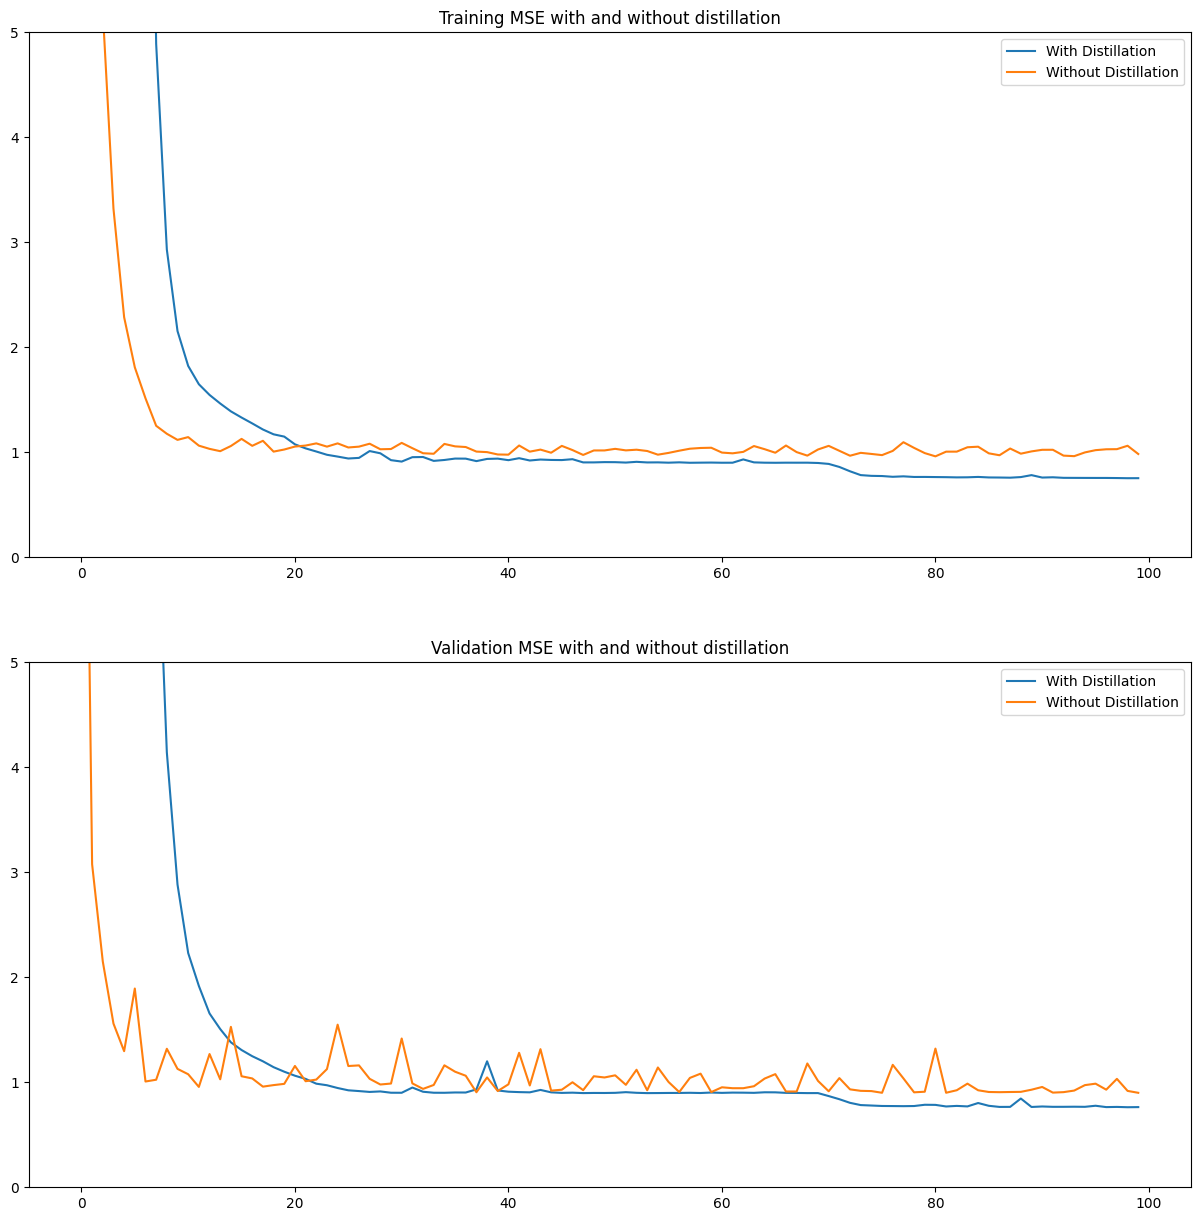

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.6935 +- 0.2386
Validation mse without disstillation 0.7242 +- 0.0901


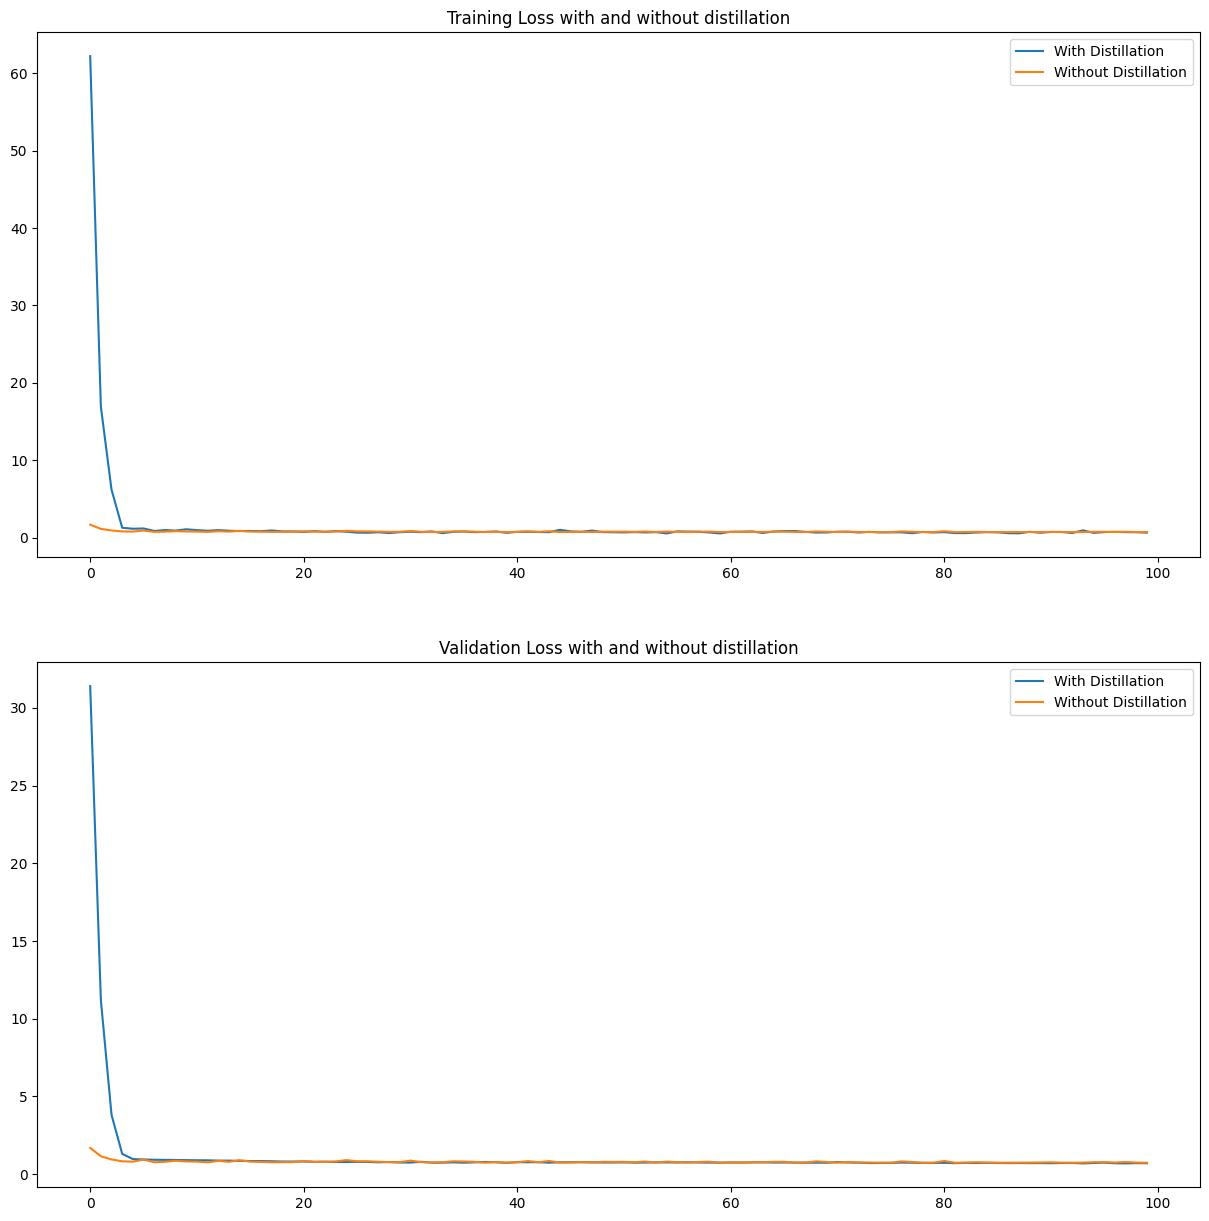

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 3.8457 - mae: 1.6960 - mape: 84.0755 - student_loss: 1.6940 - distillation_loss: 3.3803
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 2.5588 - mae: 1.2776 - mape: 57.2700 - student_loss: 1.2772 - distillation_loss: 2.1007
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 1.7573 - mae: 0.9971 - mape: 45.2460 - student_loss: 0.9974 - distillation_loss: 1.3093
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 1.3071 - mae: 0.8486 - mape: 43.6166 - student_loss: 0.8499 - distillation_loss: 0.8599
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 1.0822 - mae: 0.7853 - mape: 46.4534 - student_loss: 0.7852 - distillation_loss: 0.6383
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9901 - mae: 0.7705 - mape: 50.2593 - student_loss: 0.7700 - distillation_loss: 0.5499
Epoch 7/100
492/492 [=======

492/492 [==============================] - 1s 2ms/step - mse: 0.9518 - mae: 0.7814 - mape: 55.9436 - student_loss: 0.7809 - distillation_loss: 0.5137
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9515 - mae: 0.7819 - mape: 56.1136 - student_loss: 0.7814 - distillation_loss: 0.5149
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9517 - mae: 0.7816 - mape: 56.0063 - student_loss: 0.7808 - distillation_loss: 0.5143
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9516 - mae: 0.7821 - mape: 56.1444 - student_loss: 0.7821 - distillation_loss: 0.5152
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9517 - mae: 0.7819 - mape: 56.0942 - student_loss: 0.7819 - distillation_loss: 0.5131
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9516 - mae: 0.7819 - mape: 56.0848 - student_loss: 0.7822 - distillation_loss: 0.5132
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 88.2740 - mse: 31125.4121 - mae: 88.2740 - mape: 5825.2017
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 1.7314 - mse: 4.0073 - mae: 1.7314 - mape: 88.3869
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 1.2869 - mse: 2.6095 - mae: 1.2869 - mape: 59.1639
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9891 - mse: 1.7456 - mae: 0.9891 - mape: 45.9508
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8466 - mse: 1.3058 - mae: 0.8466 - mape: 44.5332
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7909 - mse: 1.1157 - mae: 0.7909 - mape: 46.4428
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7761 - mse: 1.0407 - mae: 0.7761 - mape: 48.7865
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7733 - mse: 1.0133 - mae: 0.7733 - mape: 50.0

492/492 [==============================] - 1s 2ms/step - loss: 0.7698 - mse: 0.9855 - mae: 0.7698 - mape: 50.4643
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9853 - mae: 0.7697 - mape: 50.4715
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7699 - mse: 0.9848 - mae: 0.7699 - mape: 50.5443
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9861 - mae: 0.7697 - mape: 50.4240
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9852 - mae: 0.7697 - mape: 50.4903
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9860 - mae: 0.7697 - mape: 50.4310
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9847 - mae: 0.7697 - mape: 50.5254
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9853 - mae: 0.7697 - mape: 50.47

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 1.3283190727233887, 'mae': 0.8795461654663086, 'mape': 57.10892105102539, 'student_loss': 0.793686032295227}
Test mse without disstillation {'loss': 0.8677904009819031, 'mse': 1.4004796743392944, 'mae': 0.8677904009819031, 'mape': 51.163597106933594}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
